In [1]:
#good for information gain
# https://www.bogotobogo.com/python/scikit-learn/scikt_machine_learning_Decision_Tree_Learning_Informatioin_Gain_IG_Impurity_Entropy_Gini_Classification_Error.php

#good for splitting
# https://lethalbrains.com/learn-ml-algorithms-by-coding-decision-trees-439ac503c9a4

#good for tree building
# https://machinelearningmastery.com/implement-decision-tree-algorithm-scratch-python/

In [2]:
#each input has to be float/int
#use np.unique to convert categorical data to int

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import copy

In [4]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

In [5]:
def hierarchy_pos(G, root=None, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5):

    if not nx.is_tree(G):
        raise TypeError('cannot use hierarchy_pos on a graph that is not a tree')

    if root is None:
        if isinstance(G, nx.DiGraph):
            root = next(iter(nx.topological_sort(G)))  #allows back compatibility with nx version 1.11
        else:
            root = random.choice(list(G.nodes))

    def _hierarchy_pos(G, root, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5, pos = None, parent = None):


        if pos is None:
            pos = {root:(xcenter,vert_loc)}
        else:
            pos[root] = (xcenter, vert_loc)
        children = list(G.neighbors(root))
        if not isinstance(G, nx.DiGraph) and parent is not None:
            children.remove(parent)  
        if len(children)!=0:
            dx = width/len(children) 
            nextx = xcenter - width/2 - dx/2
            for child in children:
                nextx += dx
                pos = _hierarchy_pos(G,child, width = dx, vert_gap = vert_gap, 
                                    vert_loc = vert_loc-vert_gap, xcenter=nextx,
                                    pos=pos, parent = root)
        return pos


    return _hierarchy_pos(G, root, width, vert_gap, vert_loc, xcenter)

In [6]:
def impurity(data,method):
    
    output=0.0
    
    for i in set(data):      
                    
        prob=list(data).count(i)/len(data)
        
        if method=='gini':
            output+=prob**2
        
        #entropy
        else:
            output+=prob*(np.log(prob)/np.log(2))
    
    extra=1 if method=='gini' else 0
    
    return extra-output
    

In [7]:
def information_gain(parent,left,right,method):
    
    leftc=len(left)/len(parent)
    rightc=len(right)/len(parent)
    
    sumc=leftc*impurity(left,method)+rightc*impurity(right,method)
    
    return impurity(parent,method)-sumc    

In [8]:
def node_split(df,x,y,method):
    
    info=99.99 if method=='gini' else 0.0
    target=0.0
    
    for i in df[x].tolist():

        left=df[y].loc[df[x]<i].tolist()
        right=df[y].loc[df[x]>=i].tolist()
        
        temp=information_gain(df[y].tolist(),left,right,method)
        
        if info>temp and method=='gini':
            info=temp
            target=i
            
        if info<temp and method=='entropy':
            info=temp
            target=i
            
    return target,info

In [9]:
def factors_split(df,y,method):
    
    output=pd.DataFrame()
    
    for i in df.columns:
        
        if i!=y:

            target,info=node_split(df,i,y,method)
            output[i]=[target,info]
        
    output=output.T
    output.reset_index(inplace=True)
    output.columns=['colname','target','info']
    output.sort_values(by='info',inplace=True,
                       ascending=True if method=='gini' else False)
    output.reset_index(inplace=True,drop=True)
    
    return output

In [10]:
def build_tree(df,parentname,tree,xcol,ycol,
               max_tree_depth=1000,min_node_num=2,method='gini'):

    temp=df.loc[tree.nodes[parentname]['data']]

    guide=factors_split(temp,ycol,method)
    target=guide['target'][0]
    colname=guide['colname'][0]
    
    left=temp.loc[temp[colname]<target].index.tolist()
    right=temp.loc[temp[colname]>=target].index.tolist()

    if len(parentname)>=max_tree_depth: 
        ind=tree.nodes[parentname]['data']
        nx.set_node_attributes(tree,{parentname:{'label':max(df[ycol].loc[ind].tolist(),
                                                 key=df[ycol].loc[ind].tolist().count)}})
        
        return

    if not left or not right:

        ind=tree.nodes[parentname]['data']
        nx.set_node_attributes(tree,{parentname:{'label':max(df[ycol].loc[ind].tolist(),
                                                 key=df[ycol].loc[ind].tolist().count)}})
        
        return

    if len(df[ycol].loc[left].unique())==1:
        tree.add_node(f'{parentname}L',data=left,
                      target=target,colname=colname,
                      label=df[ycol].loc[left].iloc[0]
                     )

        tree.add_edge(f'{parentname}', f'{parentname}L')


    else:

        if len(left)>min_node_num:
            tree.add_node(f'{parentname}L',data=left,
                          target=target,colname=colname
                         )

            tree.add_edge(f'{parentname}', f'{parentname}L')
            
            build_tree(df,f'{parentname}L',tree,
                       xcol,ycol,method=method)

        else:
            tree.add_node(f'{parentname}L',data=left,
                          target=target,colname=colname,
                          label=max(df[ycol].loc[left].tolist(),
                                    key=df[ycol].loc[left].tolist().count)
                         )

            tree.add_edge(f'{parentname}', f'{parentname}L')



    if len(df[ycol].loc[right].unique())==1:
        tree.add_node(f'{parentname}R',data=right,
                      target=target,colname=colname,
                      label=df[ycol].loc[right].iloc[0]
                     )

        tree.add_edge(f'{parentname}', f'{parentname}R')

    else:

        if len(right)>min_node_num:
            tree.add_node(f'{parentname}R',data=right,
                          target=target,colname=colname
                         )
            tree.add_edge(f'{parentname}', f'{parentname}R')
            
            build_tree(df,f'{parentname}R',tree,
                       xcol,ycol,method=method)

        else:
            tree.add_node(f'{parentname}R',data=left,
                          target=target,colname=colname,
                          label=max(df[ycol].loc[left].tolist(),
                                    key=df[ycol].loc[left].tolist().count)
                         )

            tree.add_edge(f'{parentname}', f'{parentname}R')

In [11]:
iris=load_iris()

df=pd.DataFrame(iris.data,columns=['x0','x1','x2','x3'])
df['y']=iris.target


In [12]:
xcol=['x0','x1','x2','x3']
ycol='y'

In [13]:
tree=nx.DiGraph()

In [14]:
method='entropy'

In [15]:
guide=factors_split(df,ycol,method)
target=guide['target'][0]
colname=guide['colname'][0]

In [16]:
tree.add_node('0',data=df.index.tolist(),
             target=target,colname=colname)

In [17]:
parentname='0'

In [18]:
build_tree(df,parentname,tree,xcol,ycol,method=method)

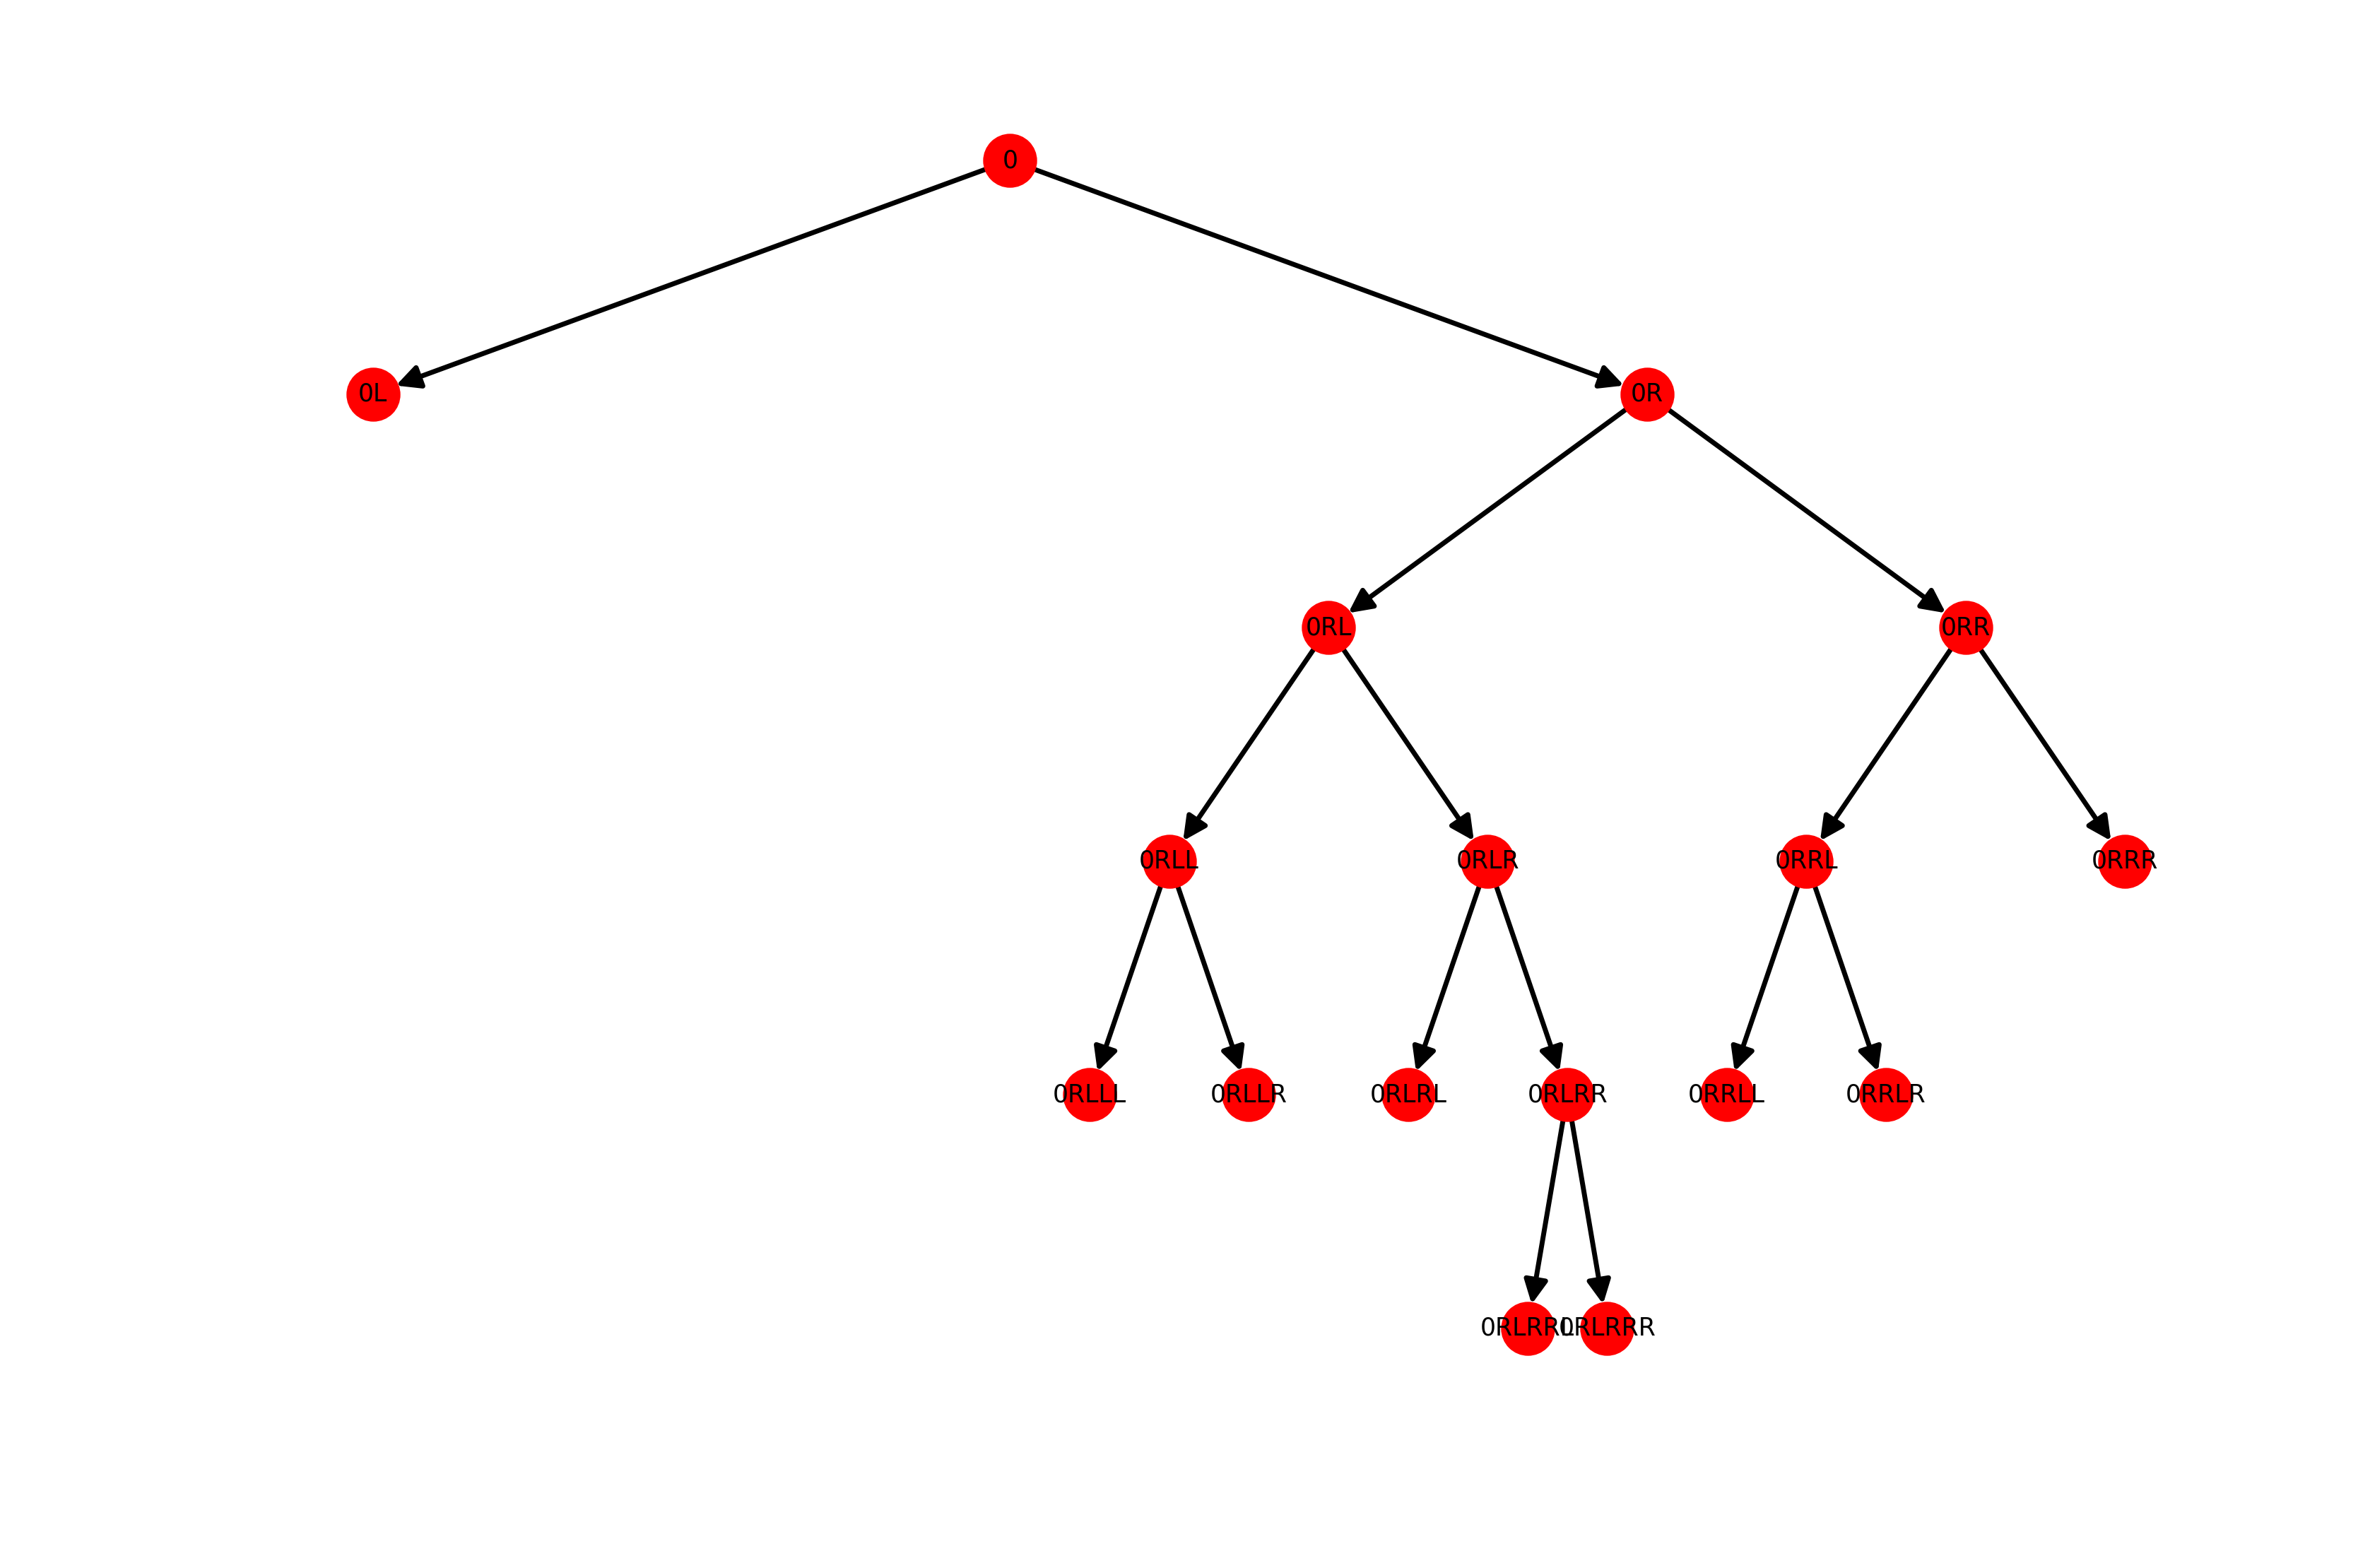

In [19]:
ax=plt.figure(dpi=500)
nx.draw(tree,with_labels=True,
        node_size=100,pos=hierarchy_pos(tree,'0'),
        font_size=5)

In [20]:
df2=copy.deepcopy(df)

In [21]:
def predict(tree,nodename,data,ind):

    colname=tree.nodes[nodename]['colname']
    target=tree.nodes[nodename]['target']
    edges=[i[1] for i in tree.edges(nodename)]

    if not edges:
        forecast=tree.nodes[nodename]['label']
        return forecast
    
    if data[colname].iloc[ind]<target:
        nodename=edges[0]
    else:
        nodename=edges[1]
        
    forecast=predict(tree,nodename,data,ind)
    
    return forecast

In [22]:
forecast=[]
for i in df2.index.tolist():
    
    forecast.append(predict(tree,'0',df2,i))

In [23]:
df2['projection']=forecast

In [24]:
len(df2[df2['y']==df2['projection']])/len(df2)

0.96